In [7]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from get_dataframes import get_global_df, datasets_df

In [8]:
results_path = "../../../experiments/final_experiments"

global_df = get_global_df(results_path=results_path)
pd.set_option('display.max_colwidth', None)

Number of FDs discovered by each algorithm for each dataset:


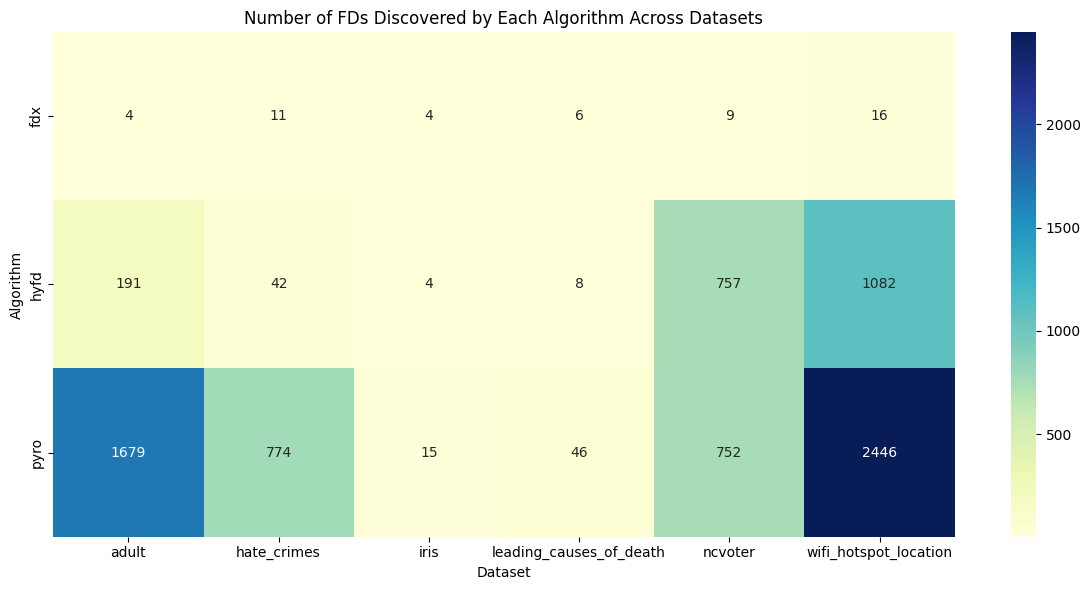

In [9]:
# Create a function to count the number of FDs for each algorithm-dataset combination
def count_fds_by_algorithm_dataset(df):
    # Group by algorithm and dataset, count the number of FDs
    counts = df.groupby(['algorithm', 'dataset']).size().reset_index(name='count')
    
    # Pivot the table to have datasets as columns and algorithms as rows
    pivot_df = counts.pivot(index='algorithm', columns='dataset', values='count')
    
    # Fill NaN values with 0
    pivot_df = pivot_df.fillna(0).astype(int)
    
    return pivot_df

# Create a matrix showing the number of FDs for each algorithm-dataset combination
fd_count_matrix = count_fds_by_algorithm_dataset(global_df)

# Display the matrix
print("Number of FDs discovered by each algorithm for each dataset:")
fd_count_matrix

# Optional: Create a heatmap visualization
plt.figure(figsize=(12, 6))
sns.heatmap(fd_count_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Number of FDs Discovered by Each Algorithm Across Datasets')
plt.ylabel('Algorithm')
plt.xlabel('Dataset')
plt.tight_layout()
plt.show()


In [11]:
data = []
results_path = "../../../datasets/final"
if os.path.exists(results_path):
    for filename in os.listdir(results_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(results_path, filename)
            df = pd.read_csv(file_path)
            num_rows = len(df)
            num_columns = len(df.columns)
            data.append([filename.split('.')[0], num_rows, num_columns])

# Create a DataFrame with dataset information
datasets_info = pd.DataFrame(data, columns=['dataset', 'num_rows', 'num_columns'])
datasets_info

,dataset,num_rows,num_columns
0,ncvoter,1000,19
1,hate_crimes,3255,14
2,wifi_hotspot_location,3319,29
3,adult,1799,15
4,leading_causes_of_death,1094,7
5,iris,150,5
